Processing the frequency spectrum of a pulse into time lag series

In [1]:
import numpy as np
from scipy.stats.stats import pearsonr
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time

from os.path import exists 
from GPbaseband1 import *

#Using latex rendering:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

if exists('./figures/correlation_coeff/giant_pulses{}chan.npz'.format(nchan)):
    with np.load('./figures/correlation_coeff/giant_pulses{}chan.npz'.format(nchan)) as npzfile:
        freq_values = npzfile['freq_values']
        time_values = npzfile['time_values']
        noise_sigma_values = npzfile['noise_sigma_values']
    #load the giant pulse average smoothed and normalized:
    gpab=np.load('./figures/correlation_coeff/gpa_smoothed.npy')

/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# with open('good_pulses.txt','w') as f:
#     for i in range(259):
#         f.write('{}\n'.format(time_values[i]))        

Loading a giant pulse 

In [9]:
fgp1bg.shape
np.mean(fgp1bg,axis = 1)

array([ 18650.04080693,  18561.84904067,  18464.43458308,  19921.52505908,
        19526.58792827,  19306.82044607,  17534.71864817,  19046.70240249])

In [47]:
fs1.shape

(264, 11)

`%matplotlib` prevents importing * from pylab and numpy
/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:49: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Populating the interactive namespace from numpy and matplotlib
std1 = 882.985433724
std2 = 889.311422883
std1 = 530.773672045
std2 = 533.722654516
std of pulse1 is  [[ 13411.66707358  15286.25849682  15450.27503261   4402.74916656
    1925.94420991   2432.89554651    983.58038936   1557.67430956
    1193.77314589   1529.17227674    914.49638519]
 [  5149.87145836   9633.1855063    4372.00698731   3499.64301315
    2271.02855254   1745.72512299   1168.34565568   1574.07311616
    1197.80411214    873.19291086   1080.12890451]
 [  5265.90092225  10813.34044611  10084.76953415   4398.38739569
    2992.37884466   2476.66842746   1667.70143802   1947.99828863
    1472.73121527    988.00633404   1061.35261428]
 [  5478.65965842  11293.78597671   6076.15521976   4751.38264374
    2028.27525064   2365.31657614   1358.4525921    1550.82062768
     915.02698688    830.5985518    1583.69047347]
 [  5776.21336792  11617.70873712   5491.19287433   6507.60647149
    3657.35407824   1559.59977832   2

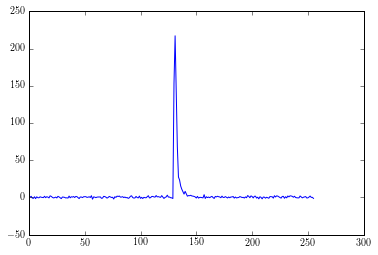

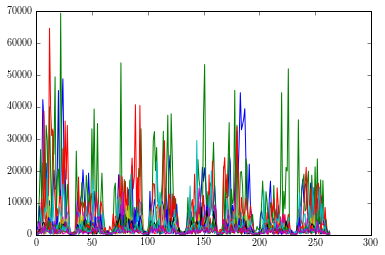

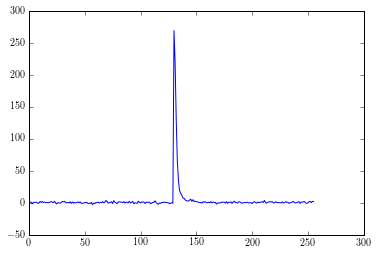

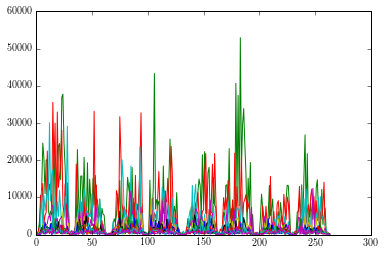

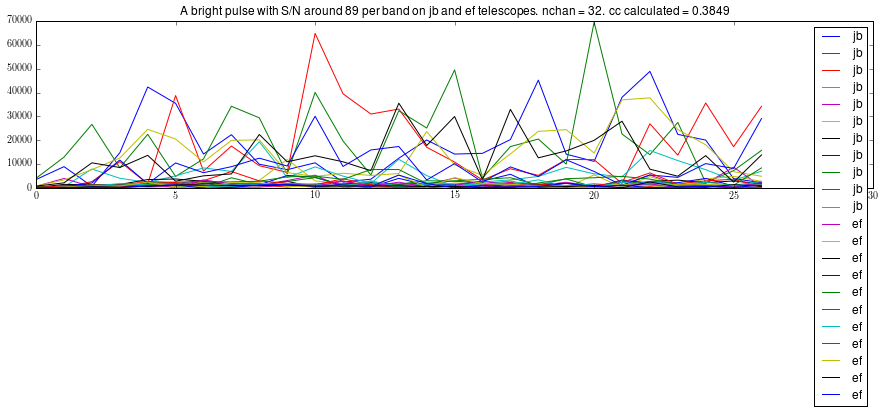

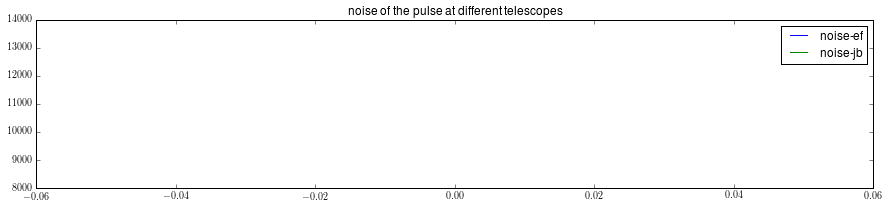

In [49]:
def get_SN(outputsumfreq):
    noise_std = np.std(outputsumfreq[:5]) 
    noise_mean = np.mean(outputsumfreq[:5])
    sigs_noise = (outputsumfreq-noise_mean)/noise_std
#     print 'standard deviation of noise is ', noise_std, 'the mean noise is ', noise_mean
    return sigs_noise

def process_freq_spec(gp1,nchan,index=None,draw=0):
    '''function takes a continuous frequency spectrum and cuts it into 8 bands, divide by the giant pulse mean, and normalize it by itself gp1=freq_spec[i]. function also plots the frequency spectrum'''
    gp1_8=np.array([gp1[int(40./512*nchan):int(465./512*nchan)]])
    for j in range(7):gp1_8=np.append(gp1_8,np.array([gp1[(j+1)*(nchan+1)+int(40./512*nchan):(j+1)*(nchan+1)+int(465./512*nchan)]]),0)
#     gp1_8/=gpab #Dividing by giant pulse average
#     for i in range(8):gp1_8[i]=gp1_8[i]/gp1_8[i].mean()-1.
    if draw:
        f,axarr=plt.subplots(8,1,figsize=(10,15))

        for i in range(8):axarr[i].plot(gp1_8[i])
        axarr[0].set_title('Frequency spectrum of giant pulse at {}'.format(time_values[index]))
    return gp1_8

def load_gp(time_string,telescope,nchan,draw = 0):
    '''Takes in a time string, a string indicating whcih telescope to use, and an interger of nchan'''
    gp1 = np.load('/home/ramain/GPs/GP{}/p{}.npy'.format(telescope,time_string))
    gp1t = np.fft.irfft(gp1,axis=1)
    gp1s = gp1t.reshape(-1,2*nchan,16)
    gp1s = np.fft.rfft(gp1s,axis=1)
    dchan = gp1s
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    output = (abs(dR)**2 + abs(dL)**2).T


    outputsumfreq = output.sum(0) #dedispersed
    #computes signal to noise after summing all the frequencies
    sigs_noise = get_SN(outputsumfreq)
    
    S_N = max(sigs_noise)
    peak_time = np.argmax(sigs_noise)
    figure()
    plot(sigs_noise)
    
    if nchan ==512:
        background_std1 = output[40./512*nchan:465./512*nchan,:peak_time-1].std()
        print 'std1 =',background_std1
        background_std2 = output[:,peak_time+2:].std()
        output_pulse = output[:,peak_time]
        print 'std2 =',background_std2
    if nchan ==32:
        background_std1 = output[40./512*nchan:465./512*nchan,:peak_time-1].std()
        print 'std1 =',background_std1
        background_std2 = output[:,peak_time+10:].std()
        output_pulse = output[:,peak_time-1:peak_time+10]
        print 'std2 =',background_std2
    
    background_freq = output[:,peak_time-2]
#     freq_spec = output_pulse-background_freq
    freq_spec = output_pulse
    figure()
    plot(output_pulse)
    plot(background_freq)
    
    if draw:
        figure(figsize = (10,3))
        plot(outputsumfreq)
    return freq_spec,background_std1

text_name = 'good_pulses.txt'
with open(text_name, 'r') as f:
    text = f.read()
    text_lines = text.split('\n')

%pylab inline
i = 235
nchan = 32
tele1 = 'jb'
tele2 = 'ef'
time_string1 = '2015-10-19T00:17:47.415' # S/N = 89!, main pulse 
time_string2 = '2015-10-19T02:35:26.143' # S/N = 43, main pulse 
time_string3 = '2015-10-19T02:06:52.280' #S/N = 7.9, inter pulse
time_string4 = '2015-10-19T02:06:58.031' #S/N = 9.6, main pulse
time_string5 = '2015-10-19T00:55:15.557' #S/N = 8.33, main pulse
time_string6 = '2015-10-19T00:55:49.673' #S/N = 8.55, main pulse
S_N3= 7.9
S_N4 = 9.6

fs1,bgstd1 = load_gp(time_string2,tele1,nchan)
fs2,bgstd2 = load_gp(time_string2,tele2,nchan)

fgp1 = process_freq_spec(fs1,nchan,i-1,draw = 0)
fgp2 = process_freq_spec(fs2,nchan,i-1, draw = 0)


print 'std of pulse1 is ', np.std(fgp1,axis = 1)

# print '\nmean of noise1 is ', np.mean(fgp1bg,axis = 1)
# print 'mean of pulse 1 is ', np.mean(fgp1,axis = 1)

print '\n std of pulse2 is ', np.std(fgp2,axis = 1)
# print 'std of noise2 is ', np.std(fgp2bg,axis = 1)
# print '\nthe ratio of sigma noise/sigma pulse2 is ', np.std(fgp2bg,axis =1)/np.std(fgp2,axis = 1)


# plot_2_freq(fgp1,fgp2,[i-1,i-1])
# plot_2_timelag(tgp1,tgp2,[i-1,i-1])
def get_cc((fs1,bgstd1),(fs2,bgstd2)):
    mean1 = np.mean(fs1)
    mean2 = np.mean(fs2)
    numerator = np.mean((fs1-mean1)*(fs2-mean2))
    denominator = np.sqrt(((np.std(fs1))**2-bgstd1**2)*((np.std(fs2))**2-bgstd2**2))
#     denominator = np.std(fs1)*np.std(fs2)
    return numerator/denominator
    
def get_ccs((fs1,bgstd1),(fs2,bgstd2)):
    coefficients= []
    for i in range(8):
        X = fs1[i]
        Y = fs2[i]
#         Xbg = bgstd1[i]
#         Ybg = fs2bg[i]
        coefficient = get_cc((X,bgstd1),(Y,bgstd2))
        coefficients.append(coefficient) 
    return np.mean(coefficients),coefficients

cc,ccs=get_ccs((fgp1,bgstd1),(fgp2,bgstd2))
print '\nthe two pulses are', cc ,'correlated'
print ccs

print 'numerator for 1st band:', np.mean((fgp1[0]-fgp1[0].mean())*(fgp2[0]-fgp2[0].mean()))
print 'denominator for 1st band:', np.sqrt(((np.std(fgp1[0]))**2-bgstd1**2)*((np.std(fgp2[0]))**2-bgstd2**2))

figure(figsize = (15,3))
plot(fgp1[0],label = tele1)
plot(fgp2[0],label = tele2)
title('A bright pulse with S/N around 89 per band on {} and {} telescopes. nchan = {}. cc calculated = {}'.format(tele1,tele2,nchan,round(ccs[0],4)))
legend()

figure(figsize = (15,3))
plot(fs1bg,label = 'noise-ef')
plot(fs2bg,label = 'noise-jb')
title('noise of the pulse at different telescopes')
legend()

FOr testing getting rid of noise:

In [5]:
#For testing binning!
# figure()
# binning_constant = np.histogram(np.linspace(0,15,213),np.linspace(0,15,16))[0]
# hist = np.histogram(np.linspace(0,15,213),np.linspace(0,15,16),weights = abs(tgp1[0]))[0]
# # plot(hist)
# # plot(binning_constant)
# plot(np.linspace(0,15,213),abs(tgp1[0]))
# plot(np.linspace(0,15,15),hist/binning_constant)

In [70]:
def bin_data(t,a,bins):
    '''This function takes in t( an array of time values), a (array of data), and the bins and return an array of the binned data a'''
    a_binned = np.histogram(t,bins,weights = a,density = False)[0]/np.histogram(t,bins,density = False)[0]
    return a_binned 

def transform_to_timelag(fgp,index= None,draw = 0,binned=0):
    if binned ==0:
        N = 213
        tgp=np.zeros(shape=(0,N))
        for i in range(8):tgp=np.append(tgp,np.array([np.fft.rfft(fgp[i])]),0)
    else:
        N = 15
        tgp = np.zeros(shape=(0,N))
        for i in range(8):
            a = np.fft.rfft(fgp[i])
            tgp=np.append(tgp,np.array([bin_data(np.linspace(0,15,213),abs(a),np.linspace(0,15,16))]),0)    
    if draw:
        f,axarr=plt.subplots(8,1,figsize=(10,15))
        for i in range(8):axarr[i].plot(np.linspace(0,15,N),abs(tgp[i]))
        axarr[0].set_title('Time lag spectrum of giant pulse at {}'.format(time_values[index]))
        axarr[7].set_xlabel('Time lag(\mu s)')
    return tgp


# tgp1b = transform_to_timelag(fgp1,draw = 0,binned = 1)
# tgp2b = transform_to_timelag(fgp2,draw = 0,binned = 1)
# tgp1 = transform_to_timelag(fgp1,draw = 0,binned = 0)
# tgp2 = transform_to_timelag(fgp2,draw = 0,binned = 0)
# N=tgp1[0].shape[0]
# f,axarr=plt.subplots(8,1,figsize=(10,15))
# for k in range(8):
#     #normalized,binned:
# #     axarr[k].plot(np.linspace(0,15,N),(abs(tgp1b[k]))/np.mean(abs(tgp1b[k]))-1,label = tele1)
# #     axarr[k].plot(np.linspace(0,15,N),(abs(tgp2b[k]))/np.mean(abs(tgp2b[k]))-1,label = tele2)
#     #original units, binned:
# #     axarr[k].plot(np.linspace(0,15,15),abs(tgp1b[k]),label = tele1+' binned')
# #     axarr[k].plot(np.linspace(0,15,15),abs(tgp2b[k]),label = tele2+' binned')
#     #original units, not binned:
#     axarr[k].plot(np.linspace(0,15,213),abs(tgp1[k]),'b',label = tele1)
#     axarr[k].plot(np.linspace(0,15,213),abs(tgp2[k]),'g',label = tele2)
    
# axarr[0].set_title('Time lag spectrum of giant pulse at {} (S/N ={}) on telescopes {} and {}'.format(time_string4,S_N4,tele1,tele2))
# axarr[7].set_xlabel('Time lag(\mu s)')
# legend(loc=(0.95,0.5))


In [7]:
text_lines[i-1]

'2015-10-19T02:35:26.143'

In [66]:
nchan = 512

def plotmean(tgp10):
    figure(figsize=(10,6))
    plot(np.linspace(0,16,213),abs(tgp10).mean(0))
    title('Mean of time lag spectrum')
    
def find_std(tgp,draw = 0):
    stda=np.std(tgp,axis=0) #numpy's std deals with complex numbers: std = sqrt(mean(abs(x - x.mean())**2)) 
    return stda
    if draw:
        figure(figsize=(10,6))
        plot(np.linspace(0,16,213),stda)
        title('Standard deviation as a function of time lag')

def plot_2_freq(fgp1,fgp2,index):
    '''index is an list of 2 indices'''
    f,axarr=plt.subplots(8,1,figsize=(10,15))
    for i in range(8):
        axarr[i].plot(fgp1[i])
        axarr[i].plot(fgp2[i])
    axarr[0].set_title('Frequency spectrum of giant pulse at {}, {}'.format(time_values[index[0]],time_values[index[1]]))
    axarr[7].set_xlabel('Frequency channels (512 channels per 16MHz = 0.03MHz per channel)')

def plot_2_timelag(tgp1,tgp2,index):
    '''index is an list of 2 indices'''
    f,axarr=plt.subplots(8,1,figsize=(10,15))
    for i in range(8):
        axarr[i].plot(np.linspace(0,15,213),abs(tgp1[i]))
        axarr[i].plot(np.linspace(0,15,213),abs(tgp2[i]))
    axarr[0].set_title('Time lag spectrum of giant pulse at {}, {}'.format(time_values[index[0]],time_values[index[1]]))
    axarr[7].set_xlabel(r'Time lag(\mu s)')


Function to compute the correlation coefficient

In [68]:
# bgstd = np.load('./figures/correlation_coeff/backgroundstd.npy')

def find_cc((fs1,fs1bg),(fs2,fs2bg), binned = 0, bin_no=16):
    '''This find_cc function uses Robert\'s .npy pulses, with a different bg noise for each pulse''' 
    print fs1.shape
    fgp1=process_freq_spec(fs1,nchan,draw=0) #-1 if getting i from .txt file. i only needed for plotting
    fgp1bg=process_freq_spec(fs1bg,nchan,draw=0)
    tgp1=transform_to_timelag(fgp1,draw = 0)
    tgp1bg = transform_to_timelag(fgp1bg,draw = 0)
    print tgp1.shape
    fgp2=process_freq_spec(fs2,nchan,draw=0)
    tgp2=transform_to_timelag(fgp2,draw = 0)
    fgp2bg=process_freq_spec(fs2bg,nchan,draw=0)
    tgp2bg=transform_to_timelag(fgp2bg,draw = 0) 
    
    time_lag_values = np.linspace(0,15,213)
    if binned:
#         bins = np.logspace(np.log10(time_lag_values[1]),np.log10(15),bin_no)
        bins = np.linspace(0,15,bin_no)
        numerator_8 = np.zeros(shape = (0,bin_no-1))
    else:
        numerator_8 = np.zeros(shape = (0,213))
        
    for k in range(8):
        if binned:
            numerator = np.real(tgp1[k]*np.conj(tgp2[k]))
            numerator_8 = np.append(numerator_8,np.array([bin_data(time_lag_values,numerator,bins)]),0)
        else:
            numerator_8 = np.append(numerator_8,np.array([tgp1[k]*np.conj(tgp2[k])]),0)
    
    bgstd1=find_std(tgp1bg)
    bgstd2=find_std(tgp2bg)
#     print bgstd1[:10]
#     print bgstd2[:10]
    numerator = numerator_8.mean(0)
     
#     tgp1b = np.zeros(shape = (0,bin_no-1))
#     tgp2b = np.zeros(shape = (0,bin_no-1))
#     for k in range(8):
#         tgp1b = np.append(tgp1b,np.array([bin_data(time_lag_values,tgp1[k],bins)]),0)
#         tgp2b = np.append(tgp2b,np.array([bin_data(time_lag_values,tgp2[k],bins)]),0)
    
#     denominator = np.std(tgp1b)*np.std(tgp2b)
    
#     The old method of getting standard deviation
    stdgp1 = find_std(tgp1)
    print 'tgp1 has type', tgp1.dtype
    print 'stdgp1 has type',stdgp1.dtype
    stdgp2 = find_std(tgp2)
    if binned:
        stdgp1b = bin_data(time_lag_values,stdgp1,bins)
        stdgp2b = bin_data(time_lag_values,stdgp2,bins)
        bgstd1b = bin_data(time_lag_values,bgstd1,bins)
        bgstd2b = bin_data(time_lag_values,bgstd2,bins)
        denominator = np.sqrt((stdgp1b**2-bgstd1b**2)*(stdgp2b**2-bgstd2b**2))
#         denominator = stdgp1b*stdgp2b
#         denominator = bin_data(time_lag_values,np.std((tgp1*np.conj(tgp2)),axis=0),bins)
    else:
        denominator = np.sqrt((stdgp1**2-bgstd1**2)*(stdgp2**2-bgstd2**2))
#         denominator = stdgp1*stdgp2
#         denominator = np.std((tgp1*np.conj(tgp2)),axis=0)


    cc = numerator/denominator
    figure()
    if binned:
        plot(bins[:-1],denominator,label = 'denominator')
        plot(bins[:-1], numerator, label = 'numerator')
    else:
        plot(time_lag_values, numerator, label = 'numerator')
        plot(time_lag_values,denominator,label = 'denominator')
#     print 'denominator is ',denominator
#     title('Numerator and denominator of cc between {} {}'.format(tele1,))
    legend()
    return cc



Linear binning

In [159]:
tgp1

NameError: name 'tgp1' is not defined

standard deviation of noise is  599796.855195 the mean noise is  38367906.6857
standard deviation of noise is  964713.82873 the mean noise is  64258519.6573
(4104,)
(8, 213)
tgp1 has type complex128
stdgp1 has type float64
(4104,)
(8, 213)
tgp1 has type complex128
stdgp1 has type float64


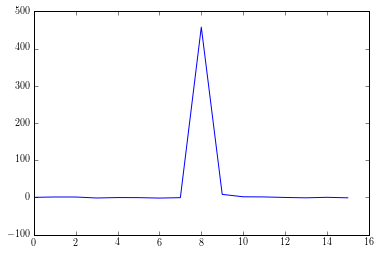

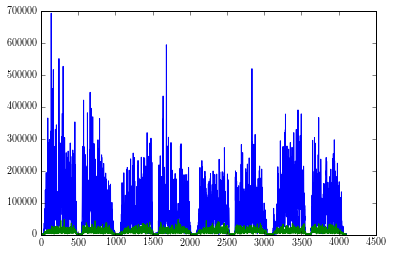

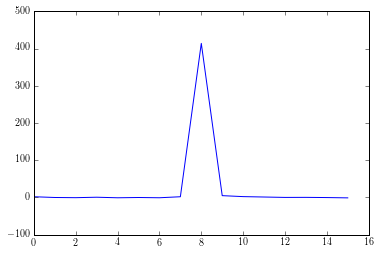

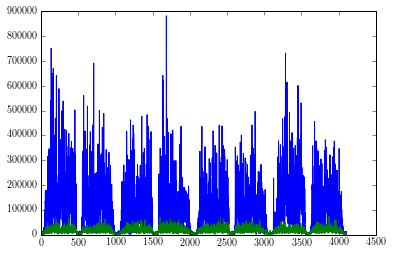

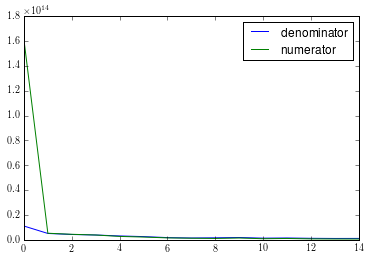

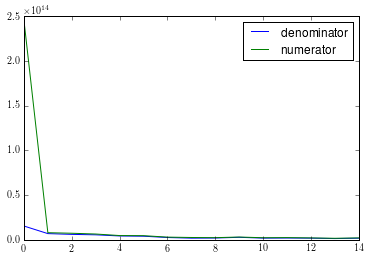

In [73]:
i = 235
j = 85
# fs1ef = load_gp(text_lines[i-1],'ef',512)
# fs2ef = load_gp(text_lines[j-1],'ef',512)
# fs1jb = load_gp(text_lines[i-1],'jb',512)
# fs2jb = load_gp(text_lines[j-1],'jb',512)
time_string1 = '2015-10-19T00:17:47.415' # S/N = 89!, main pulse 
time_string2 = '2015-10-19T02:35:26.143' # S/N = 43, main pulse 
time_string3 = '2015-10-19T02:06:52.280' #S/N = 7.9, inter pulse
time_string4 = '2015-10-19T02:06:58.031' #S/N = 9.6, main pulse

time_string5 = '2015-10-18T23:47:20.315' #S/N = 11, interpulse
time_string6 = '2015-10-18T23:47:20.807' #S/N = 11, main pulse

time_string7 = '2015-10-19T00:37:14.418' #S/N = 13, main pulse
time_string8 = '2015-10-19T00:37:15.126' #S/N = 7.2, main pulse

S_N2 = 43
S_N1 = 89
#Using robert's data
ccefjb = find_cc(load_gp(time_string1,'ef',512),load_gp(time_string1,'jb',512),binned=1)
# ccjbwb = find_cc(load_gp(time_string1,'jb',512),load_gp(time_string1,'wb',512),binned=1)
# ccefwb = find_cc(load_gp(time_string1,'ef',512),load_gp(time_string1,'wb',512),binned=1)

ccnoisetest = find_cc((gp1,noise1),(gp2,noise2),binned = 1)
#Getting data from my frequency array 
# ccef1 = find_cc1(freq_values[i-1],freq_values[j-1],binned=1)


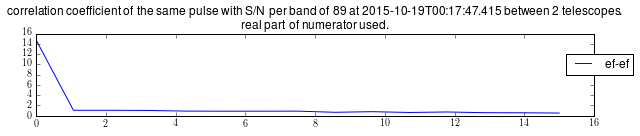

In [74]:
'''Linear plotting'''
N=ccefjb.shape[0]

figure(figsize= (10,5))
ax1 = subplot(3,1,1)
plot(np.linspace(0,15,N),ccefjb,label='ef-ef')
# ylim(-.2,.2)
axhline(y=0.,color = 'black')
# title('correlation coefficient as a function of timelag of two main pulses\n at {}, {}'.format(time_values[i-1],time_values[j-1])) 
title('correlation coefficient of the same pulse with S/N per band of {} at {} between 2 telescopes. \n real part of numerator used.'.format(S_N1,time_string1))
legend(loc=(0.95,0.5))

# ax2=subplot(3,1,2)
# plot(np.linspace(0,15,N),ccjbwb,'c',label = 'jb-jb')
# # ylim(-.2,.2)
# axhline(y=0.,color = 'black')
# # axarr[1].set_title('jb:correlation coefficient as a function of timelag of two main pulses\n at {}, {}'.format(time_values[i-1],time_values[j-1])) 
# legend(loc=(0.95,0.5))

# ax2=subplot(3,1,3)
# plot(np.linspace(0,15,N),ccefwb,'g',label='wb-wb')
# # ylim(-.2,.2)
# axhline(y=0.,color = 'black')
# xlabel(r'time lag ($\mu$s)')
# # axarr[2].set_title('wb:correlation coefficient as a function of timelag of two main pulses\n at {}, {}'.format(time_values[i-1],time_values[j-1])) 
# legend(loc=(0.95,0.5))


# '''Log plotting'''
# figure(figsize=(10,3))
# semilogx(ccef)

Log binning

/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


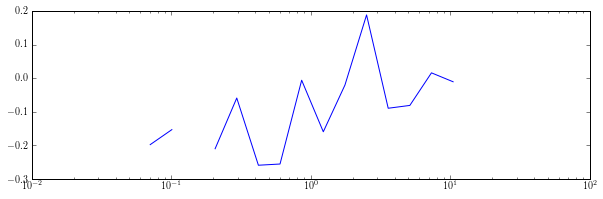

In [52]:
bin_no = 16
time_lag_values = np.linspace(0,15,213)
bins = np.logspace(np.log10(time_lag_values[1]),np.log10(15),bin_no)
cc_means = np.histogram(time_lag_values,bins,weights = cc,density = False)[0]/np.histogram(time_lag_values,bins,density = False)[0]

figure(figsize=(10,3))
semilogx(bins[:-1],cc_means)

In [27]:
%pylab inline
#load sigma noise
bgstd = np.load('./figures/correlation_coeff/backgroundstd.npy')

i = 34
j = 35
#def find_cc(i,j):
fgp1=process_freq_spec(freq_values[i-1],i,draw=0) #-1 if getting i from .txt file. i only needed for plotting
tgp1=transform_to_timelag(fgp1,i-1,draw = 0)
fgp2=process_freq_spec(freq_values[j-1],j,draw=0)
tgp2=transform_to_timelag(fgp2,j-1,draw = 0)

numerator_8 = np.zeros(shape = (0,213))
for k in range(8):
    numerator_8 = np.append(numerator_8,np.array([tgp1[k]*np.conj(tgp2[k])]),0)

numerator = np.real(numerator_8).mean(0)

stdgp1 = find_std(tgp1)
stdgp2 = find_std(tgp2)
denominator = np.sqrt((stdgp1**2-bgstd**2)*(stdgp2**2-bgstd**2))
    
cc = numerator/denominator
    #return cc

# cc = find_cc(34,35)


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
def find_cc1(fs1,fs2, binned = 0, bin_no=16):
    '''This find_cc function uses my original data freq_values, with the same background std'''
    bgstd = np.load('./figures/correlation_coeff/backgroundstd.npy')
    fgp1=process_freq_spec(fs1,draw=0) #-1 if getting i from .txt file. i only needed for plotting
    tgp1=transform_to_timelag(fgp1,draw = 0)
    fgp2=process_freq_spec(fs2,draw=0)
    tgp2=transform_to_timelag(fgp2,draw = 0)
    
    if binned:
        numerator_8 = np.zeros(shape = (0,bin_no-1))
    else:
        numerator_8 = np.zeros(shape = (0,213))
        
    for k in range(8):
        if binned:
            numerator = tgp1[k]*np.conj(tgp2[k])
            numerator_8 = np.append(numerator_8,np.array([bin_data(np.linspace(0,15,213),numerator,np.linspace(0,15,bin_no))]) ,0)
        else:
            numerator_8 = np.append(numerator_8,np.array([tgp1[k]*np.conj(tgp2[k])]),0)

    numerator = np.real(numerator_8).mean(0)
    
    stdgp1 = find_std(tgp1)
    stdgp2 = find_std(tgp2)
    if binned:
        stdgp1b = bin_data(np.linspace(0,15,213),stdgp1,np.linspace(0,15,bin_no))
        stdgp2b = bin_data(np.linspace(0,15,213),stdgp2,np.linspace(0,15,bin_no))
        bgstdb = bin_data(np.linspace(0,15,213), bgstd ,np.linspace(0,15,bin_no))
#         denominator = np.sqrt((stdgp1b**2-bgstdb**2)*(stdgp2b**2-bgstdb**2))
        denominator = np.sqrt((stdgp1b**2)*(stdgp2b**2))
    else:
#         denominator = np.sqrt((stdgp1**2-bgstd**2)*(stdgp2**2-bgstd**2))
        denominator = np.sqrt((stdgp1**2)*(stdgp2**2))

    cc = numerator/denominator
    return cc

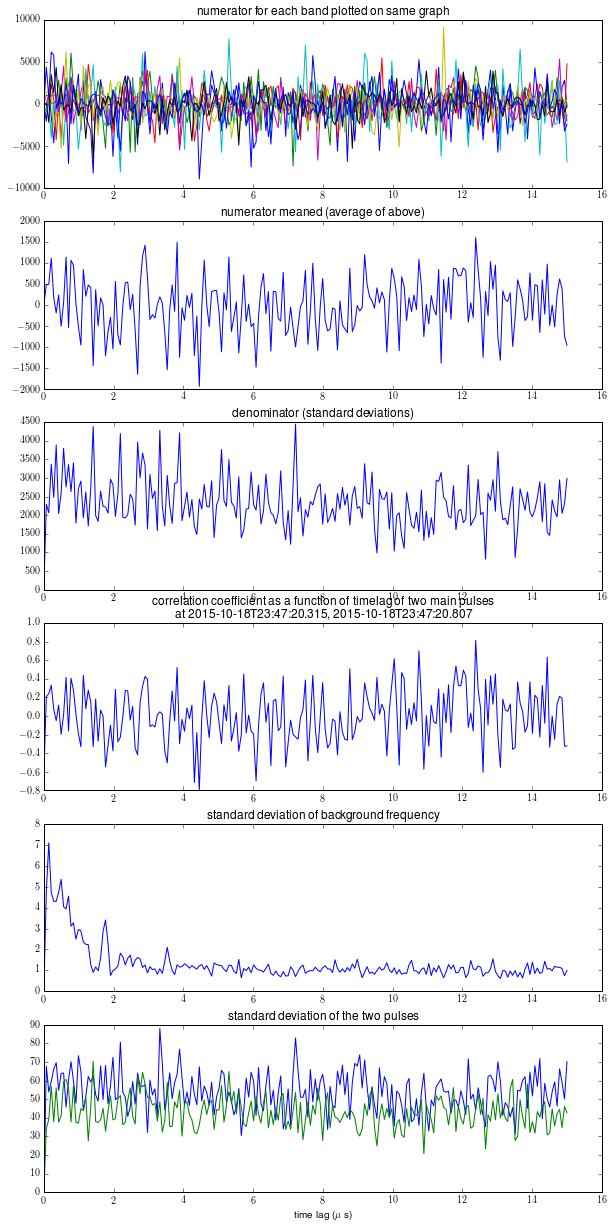

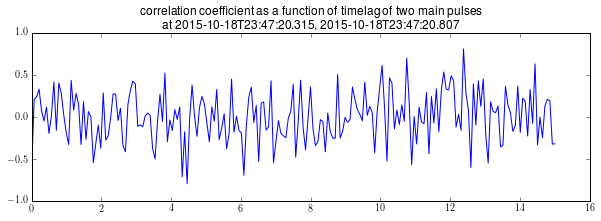

In [28]:
f,axarr=subplots(6,1,figsize=(10,21))
for k in range(8):
    axarr[0].plot(np.linspace(0,15,213),numerator_8[k])
axarr[0].set_title('numerator for each band plotted on same graph')

# figure(figsize=(10,3))
axarr[1].plot(np.linspace(0,15,213),numerator)
axarr[1].set_title('numerator meaned (average of above)')

# figure(figsize=(10,3))
axarr[2].plot(np.linspace(0,15,213),denominator)
axarr[2].set_title('denominator (standard deviations)')

# figure(figsize=(10,3))
axarr[3].plot(np.linspace(0,15,213),cc)
axarr[3].set_title('correlation coefficient as a function of timelag of two main pulses\n at {}, {}'.format(time_values[i-1],time_values[j-1])) 

axarr[4].plot(np.linspace(0,15,213),bgstd)
# axarr[4].set_xlabel(r'time lag ($\mu$ s)')
axarr[4].set_title('standard deviation of background frequency') 

axarr[5].plot(np.linspace(0,15,213),stdgp1)
axarr[5].plot(np.linspace(0,15,213),stdgp2)
axarr[5].set_xlabel(r'time lag ($\mu$ s)')
axarr[5].set_title('standard deviation of the two pulses') 

figure(figsize=(10,3))
plot(np.linspace(0,15,213),cc)
ylim(-1.,1.)
title('correlation coefficient as a function of timelag of two main pulses\n at {}, {}'.format(time_values[i-1],time_values[j-1])) 

In [32]:
a= np.array([1,2,3])
a**2
numerator_8.shape

(8, 213)

Plot the frequency spectrum and time lag spectrum of two giant pulses

Populating the interactive namespace from numpy and matplotlib


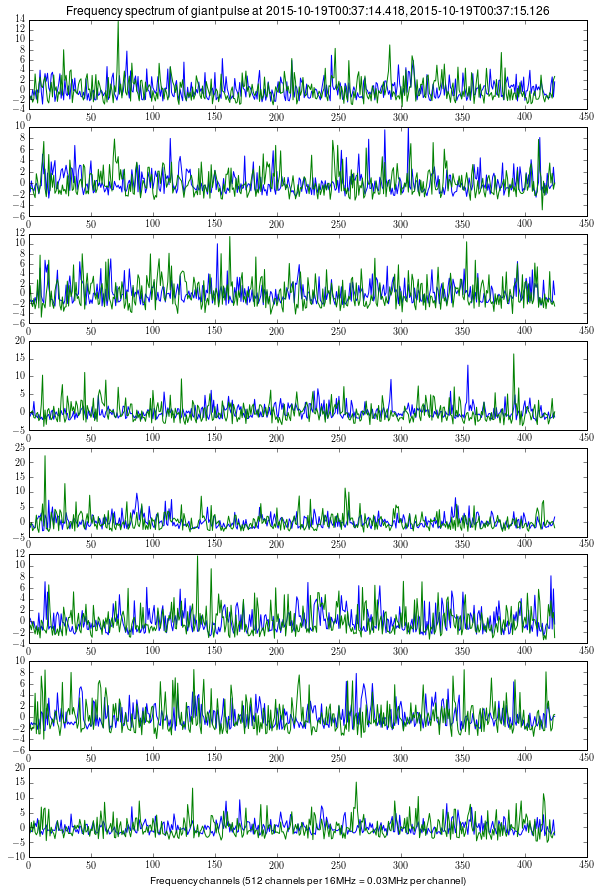

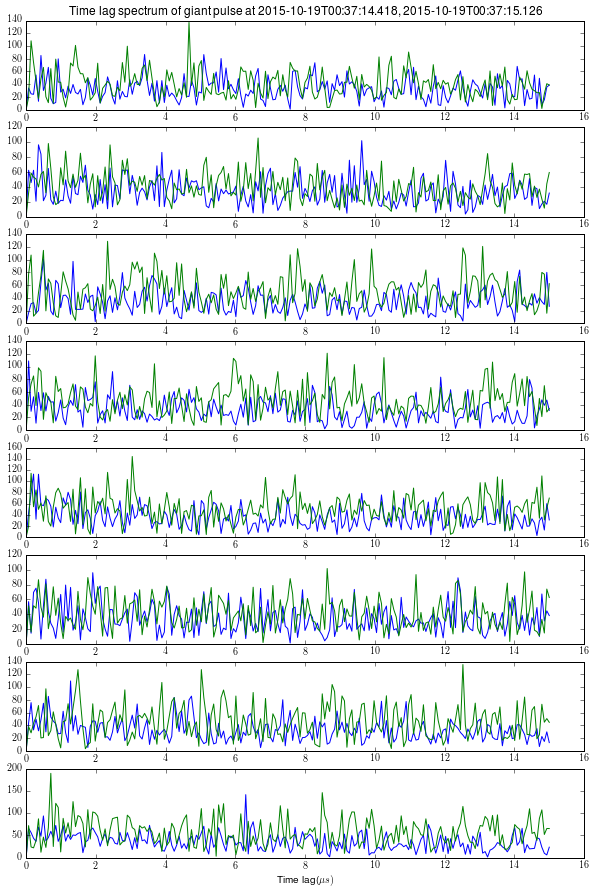

In [54]:
%pylab inline
# i=34
# j=35

fgp1=process_freq_spec(freq_values[i-1],i-1,draw=0)
tgp1=transform_to_timelag(fgp1,i)

fgp2=process_freq_spec(freq_values[j-1],j-1,draw=0)
tgp2=transform_to_timelag(fgp2,j)

plot_2_freq(fgp1,fgp2,[i-1,j-1])
plot_2_timelag(tgp1,tgp2,[i-1,j-1])


In [1]:
tgp66

NameError: name 'tgp66' is not defined

In [59]:
abs(tgp10).shape



(8, 213)